In [3]:
#jupyter notebook magic
%store -r habitats

no stored variable or alias habitats


## Data Download for Elevation 

The elevation data was sources from  NASA Shuttle Radar Topography Mission Global 1 arc second, accessed via NASA's Earthdata. 
From the data website: 
>The Land Processes Distributed Active Archive Center (LP DAAC) is responsible for the archive and distribution of the NASA Making Earth System Data Records for Use in Research Environments (MEaSUREs) version SRTM, which includes the global 1 arc second (~30 meter) product.
>NASA Shuttle Radar Topography Mission (SRTM) datasets result from a collaborative effort by the National Aeronautics and Space Administration (NASA) and the National Geospatial-Intelligence Agency (NGA - previously known as the National Imagery and Mapping Agency, or NIMA), as well as the participation of the German and Italian space agencies. The purpose of SRTM was to generate a near-global digital elevation model (DEM) of the Earth using radar interferometry. SRTM was a primary component of the payload on the Space Shuttle Endeavour during its STS-99 mission. Endeavour launched February 11, 2000 and ﬂew for 11 days.
>SRTM collected data in swaths, which extend from ~30 degrees off-nadir to ~58 degrees off-nadir from an altitude of 233 kilometers (km). These swaths are ~225 km wide, and consisted of all land between 60° N and 56° S latitude. This accounts for about 80% of Earth’s total landmass. https://lpdaac.usgs.gov/products/srtmgl1v003/

This data was use to calculate slope, since Tetraneuris grandiflora prefers mountainous meadows above treeline. 

Source
>NASA JPL. “NASA Shuttle Radar Topography Mission Global 1 Arc Second.” NASA EOSDIS Land Processes Distributed Active Archive Center, 2013. https://doi.org/10.5067/MEASURES/SRTM/SRTMGL1.003.


In [4]:
# import required libraries 
import os
import pathlib
from glob import glob

import earthaccess
import geopandas as gpd
import xrspatial
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import matplotlib.pyplot as plt
import cartopy.crs as ccrs # CRSs

In [5]:
# Set required data directories 
elev_data_dir = os.path.join(habitat_data_dir,'elevation')
os.makedirs(elev_data_dir, exist_ok=True)


NameError: name 'habitat_data_dir' is not defined

In [5]:
#login to earth access
earthaccess.login()

In [6]:
#search earth access data sets 
datasets = earthaccess.search_datasets(keyword='SRTM DEM')
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])
    

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002
GFSAD30EUCEARUMECE Global Food Security-support Analysis Data (GFSAD) Cropland Extent 2015 Europe, Central Asia, Russia, Middle East product 30 m V001
GFSAD30SA

In [24]:
# do a data search over gdf bounds and download data

#set up data path 
strm_pattern = os.path.join(elev_data_dir, '*.hgt.zip')

#set bounds and buffer, will use buffer later for plots 
bounds = tuple(teton_gdf.total_bounds)
buffer =.025
xmin, ymin, xmax, ymax = bounds
bounds_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)

if not glob(strm_pattern):
        print(bounds)
        strm_results = earthaccess.search_data(
            short_name = 'SRTMGL1',
            bounding_box=bounds
        )
        earthaccess.download(strm_results, elev_data_dir)    




<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

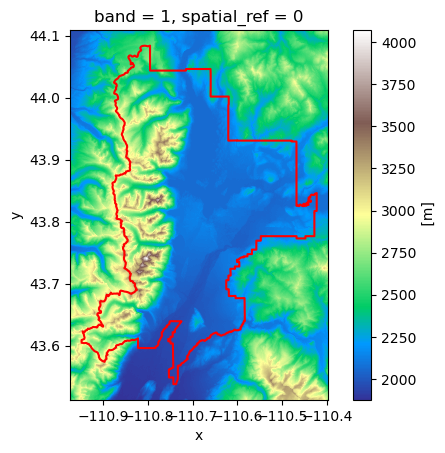

In [25]:
#merge raster files and plot data download 
strm_da_list = []

for strm_path in glob(strm_pattern):
    tile_da = rxr.open_rasterio(strm_path, mask_and_scale=True).squeeze()
    cropped_da =tile_da.rio.clip_box(*bounds_buffer)
    strm_da_list.append(cropped_da)

strm_da = rxrmerge.merge_arrays(strm_da_list)
strm_da.plot(cmap='terrain')
teton_gdf.boundary.plot(ax=plt.gca(), color ='red')

    

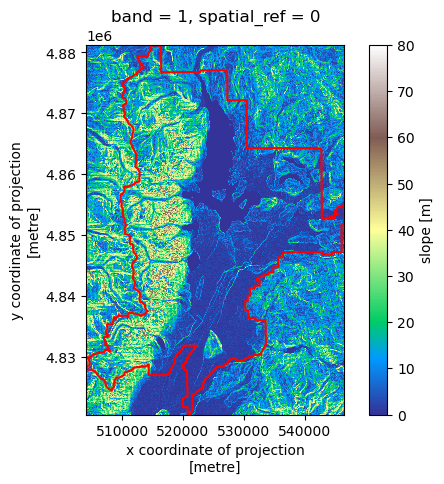

In [28]:
# project data set 
utm12_epsg=26912
srtm_proj_da = strm_da.rio.reproject(utm12_epsg)
teton_proj_gdf = teton_gdf.to_crs(utm12_epsg)
bounds_proj = tuple(teton_proj_gdf.total_bounds)

#Calculate Slope
slope_full_da = xrspatial.slope(srtm_proj_da)
slope_da = slope_full_da.rio.clip_box(*bounds_proj)

#Plot Slope
slope_da.plot(cmap='terrain')
teton_proj_gdf.boundary.plot(ax=plt.gca(), color='red')
plt.show()

In [6]:
#plot slope data 

slope_da = xrspatial.slope(strm_da)
slope_da.plot()

NameError: name 'strm_da' is not defined